# Assignment 1a - Due 10pm March 7th 2022
### By Sam Archie (53743534/sar173)

In [1]:
# Import all modules needed for this assignment
import xarray as xr
import os
import pandas as pd

### Task 1: Data Source Details
List the netcdf files present in /mnt/data/MetService_WRF, including (a) the total size of the entire folder and (b) the total count of files present in the folder.

##### Approach 1 - Through the Linux Terminal

Using the command:\
ls -Ss --block-size=M /mnt/data/MetService_WRF/ \
yields a list of size (in megabytes) for each file in the directory. The total of the filesizes is 2673175 MB which is is equivalent to 2.55 TB.

Using the command: \
ls -1 /mnt/data/MetService_WRF/ | wc -l \
yields the a value of 1251, which is the amount of lines counted in the listing command before the "|" character.

Thus, there are: \
1251 netcdf files with a total size of 2.55 terabytes in the directory.

##### Approach 2 - Through Python


To capture and store all of these details, this can be done through the os module and saved into a DataFrame table in Python.

In [2]:
def get_directory_file_details(directory):
    """
    Returns a DataFrame of all netcdf files in the given directory, detailing all filenames (relative) and filesizes (in bytes)
    """
    # Create an empty DataFrame to add records into as we find files
    netcdf_files_details = pd.DataFrame(columns=["filename", "filesize_bytes"])

    # Go through each filename in the directory, such as "T_20050901000000.nc"
    for filename in os.listdir(directory):
        # Make it an absolute path by rejoining with the base directory, such as "/mnt/data/MetService_WRF/T_20050901000000.nc"
        filepath = os.path.join(directory, filename)
        # Check to see if it is a netcdf file
        if filename.endswith(".nc") and os.path.isfile(filepath):
            # Create a DataFrame based on this one file
            temp = pd.DataFrame({"filename":filename, "filesize_bytes":os.path.getsize(filepath)}, index=[0])
            # And add it to the overall DataFrame
            netcdf_files_details = pd.concat([netcdf_files_details, temp], ignore_index=True)

    # Reset the index, just to make it look nice
    netcdf_files_details.reset_index(drop=True, inplace=True)
    return netcdf_files_details

In [3]:
directory = "/mnt/data/MetService_WRF/"

# Grab all the required details from the directory
netcdf_files_details = get_directory_file_details(directory)

# Now, generate the stats and print them.
# As 1024 bytes make up to the next sizing convention, then 1024^4 bytes make up 1 terabyte.
total_size = netcdf_files_details["filesize_bytes"].sum()/(1024)**4
amount_of_files = len(netcdf_files_details)
print(f"In {directory}, there are {amount_of_files} files resulting in a total size of {total_size:.2f} TB.")


In /mnt/data/MetService_WRF/, there are 1251 files resulting in a total size of 2.55 TB.


### Task 2: Visualisation of netcdf files

##### Task 2a: Find another variable from the dataset that is recorded at various height levels

In [4]:
# It seems that the variable is stored within the naming convention of the netcdf files, where the variable is the first part of the filename before the "_" character.
available_variables = set([filename.split("_")[0] for filename in netcdf_files_details["filename"]])
print(f"The variables in netcdf files are: {available_variables}")

The variables in netcdf files are: {'U', 'V', 'SMOIS', 'RAINNC', 'RH', 'T'}


Lets choose "T", which I imagine represents the variable "Air Temperature" and check one of the netcdf files to see what the varibale data is like.

In [5]:
chosen_variable = "T"
available_filenames = [filename for filename in netcdf_files_details["filename"] if filename.startswith(chosen_variable)]
chosen_filename = available_filenames[0] # Pick the first temperature netcdf file to examine

# Open the netcdf DataSet and exmaine the DataSet's data variables and cooridinates
dataset = xr.open_dataset(os.path.join(directory, chosen_filename))
dataset

<xarray.Dataset>
Dimensions:  (time: 720, lat: 508, lon: 472, height: 10)
Coordinates:
  * time     (time) datetime64[ns] 2005-09-01 ... 2005-09-30T23:00:00
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
  * height   (height) float64 2.0 20.0 30.0 40.0 ... 100.0 120.0 150.0 200.0
Data variables:
    T        (height, time, lat, lon) float32 ...

Here, it seems that the netcdf file does contain the "T" data variable and is recorded at several heights from 2 to 200m.

##### Task 2b: Plot a time series of Relative Humidity for the month of January of any particular year from any location at the east coast of the South Island

In [6]:
# Pick a netcdf file that contains relative humidity data (RH) over the January month
available_filenames = [filename for filename in netcdf_files_details["filename"] if filename.startswith("RH") and filename[7:9] == "01"]
chosen_filename = available_filenames[0] # Pick the first netcdf file
print(f"The netcdf file that will be visualised is: {chosen_filename}")

The netcdf file that will be visualised is: RH_20030101000000.nc


In [7]:
# Define the parameters to filter the data in order to plot it as per the instructions
lat, lon = (-43.552945, 172.5559761) # Location of Wigram, Christchurch
year = chosen_filename[3:7] # the year is in the naming convention of the filename!
time_slice = slice(f"{year}-01-01", f"{year}-01-31") # Time slice for January

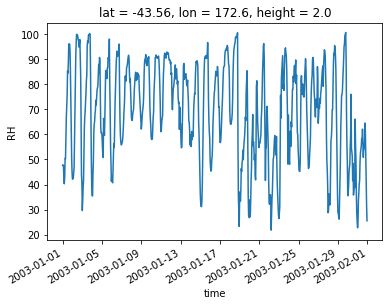

In [8]:
rh_dataset = xr.open_dataset(os.path.join(directory, chosen_filename)) # Open the dataset
rh_dataset.RH.sel(time=time_slice).sel(lat=lat, lon=lon, method="nearest").plot() # Select the data that matches the parameters and plot it

##### Task 2c: Plot a time series of air temperature at 20m above ground level for the month of January for the same location

In [9]:
# Pick a netcdf file that contains relative air temperature (T)
# May as well select the same time slice from before, so all we have to do is replace the variable in the filename
chosen_filename = chosen_filename.replace("RH", "T")

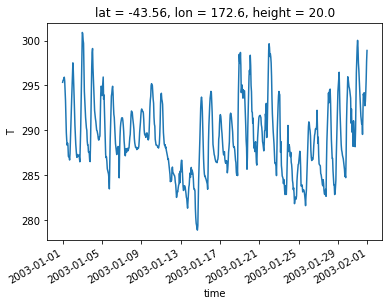

In [10]:
t_dataset = xr.open_dataset(os.path.join(directory, chosen_filename)) # Open the dataset
t_dataset.T.sel(time=time_slice, height=20).sel(lat=lat, lon=lon, method="nearest").plot() # Select the data that matches the previous parameters and plot it

##### Task 2d: Redo Tasks 2b and 2c over a 48 hour period of any two days of your choice

In [11]:
# Shorter time slice covering 1st and 2nd of January
year = chosen_filename[2:6] # the date is in the naming convention of the filename!
short_time_slice = slice(f"{year}-01-01", f"{year}-01-02")

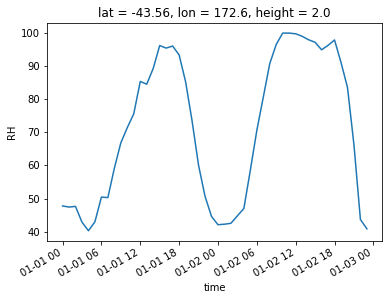

In [12]:
# Plot relative humditidy for Wigram over these 2 days
rh_dataset.RH.sel(time=short_time_slice).sel(lat=lat, lon=lon, method="nearest").plot() # Select the data that matches the parameters and plot it

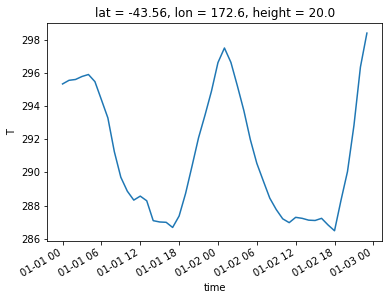

In [13]:
# Plot air temperature for Wigram over these 2 days
t_dataset.T.sel(time=short_time_slice, height=20).sel(lat=lat, lon=lon, method="nearest").plot() # Select the data that matches the previous parameters and plot it